In [ ]:
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00


In [ ]:

from google.colab import files
files.upload()

#jupytext --to ipynb Comparative_Cheb_GCN.py
!unzip numpy_data.zip

Saving numpy_data.zip to numpy_data.zip
Archive:  numpy_data.zip
  inflating: AdjacencyMatrix.npy     
  inflating: new_data.npy            
  inflating: new_labels.npy          
  inflating: NodeIndex.npy           


Comparative Chebyshev GCN

In [ ]:

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import torch
import networkx as nx
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
print(os.getcwd())

2.3.0+cu121
/content


In [ ]:
import time
#Extract Training Data

path = os.getcwd()

numpy_data = np.load(path+"/new_data.npy",allow_pickle = True)
numpy_data = np.squeeze(numpy_data)
print(numpy_data)
print(numpy_data.shape)
print(numpy_data.size)

value_data = np.load(path+"/new_labels.npy",allow_pickle = True)
print(value_data)
print(value_data.shape)
print(value_data.size)


NodeIndex = np.load(path+"/NodeIndex.npy",allow_pickle = True)
print(NodeIndex)
print(NodeIndex.shape)
print(NodeIndex.size)

AdjacencyMatrix = np.load(path+"/AdjacencyMatrix.npy",allow_pickle = True)
print(AdjacencyMatrix)
print(AdjacencyMatrix.shape)
print(AdjacencyMatrix.size)

[[[175.535 -45.7 175.535 -165.7 175.535 74.3]
  [63.3453 -75.7 63.3454 164.3 63.3454 44.3]
  [63.2984 -75.8 63.3213 164.2 63.3246 44.2]
  ...
  [73.0777 -80.0 0.0 0.0 0.0 0.0]
  [74.4743 159.5 0.0 0.0 0.0 0.0]
  [11.6567 -80.8 11.9326 158.7 11.9104 38.8]]

 [[175.535 -45.7 175.535 -165.7 175.535 74.3]
  [63.3452 -75.7 63.3453 164.3 63.3453 44.3]
  [63.257 -75.8 63.2881 164.2 63.2938 44.2]
  ...
  [69.9409 -79.6 0.0 0.0 0.0 0.0]
  [71.7593 159.4 0.0 0.0 0.0 0.0]
  [10.9096 -80.8 11.2792 158.1 11.2567 38.5]]

 [[175.535 -45.7 175.535 -165.7 175.535 74.3]
  [63.3451 -75.7 63.3452 164.3 63.3452 44.3]
  [63.2192 -75.8 63.2572 164.2 63.2654 44.2]
  ...
  [67.0804 -79.2 0.0 0.0 0.0 0.0]
  [69.2502 159.3 0.0 0.0 0.0 0.0]
  [10.2344 -80.7 10.6827 157.5 10.6626 38.2]]

 ...

 [[41827.0 30.0 41827.0 -90.0 41827.2 150.0]
  [15093.7 0.0 15093.6 -120.0 15093.6 120.0]
  [14870.7 -0.1 14882.2 -120.1 14880.5 120.0]
  ...
  [593.186 -175.4 0.0 0.0 0.0 0.0]
  [593.015 -175.5 0.0 0.0 0.0 0.0]
  [106.766 -

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch.nn.functional import normalize

encoder = ['SourceBus', '800', '802', '806', '808', '810', '812', '814', '814r', '850',
'816', '818', '824', '820', '822', '826', '828', '830', '854', '832', '858',
'834', '860', '842', '836', '840', '862', '844', '846', '848', '852r', '888', '856', '852', '864', '838', '890']
print(encoder)
print(len(encoder))
research_paper_decoder = [0,0,1,2,3,4,5,6,6,6,6,7,8,9,10,11,8,12,12,13,14,15,21,15,16,16,16,17,18,18,13,13,19,13,20,22,23]

FaultLocationLabels = value_data[:,3]

for n in range(len(FaultLocationLabels)):
    FaultLocationLabels[n]=research_paper_decoder[encoder.index(str(FaultLocationLabels[n]))]

y = FaultLocationLabels.astype("int64")
y = torch.from_numpy(y)
x = numpy_data.astype("float32")
x = torch.from_numpy(x)

NodeIndex = NodeIndex.astype("int64")
NodeIndex = NodeIndex.T
NodeIndex = torch.from_numpy(NodeIndex)

print(y)
print(y.dtype)
print(x)
print(x.dtype)
print(NodeIndex)
print(NodeIndex.dtype)
#
print(x[0])
print(normalize(x[0]))
#
result_translator = np.unique(FaultLocationLabels.astype("int64")).tolist()
print()
total_data_list = []
for n in range(len(x)):
    #print(x[n])
    #print(y[n])
    DataObject = Data(x = x[n], edge_index = NodeIndex, y = y[n], is_undirected = True) #Testing with non-normalized data
    #DataObject = Data(x = x[n], edge_index = NodeIndex, y = y[n], is_undirected = True)
    DataObject.is_undirected = True
    total_data_list.append(DataObject)
#print('Y'*888)
#print(total_data_list[0].x)

print()
#print(f'Dataset: {total_data_list}:')
print('===================')
print(f'Number of graphs: {len(total_data_list)}')
print(f'Number of features: {total_data_list[0].num_features}')
#print(f'Number of classes: {total_data_list[0].num_classes}')

data = total_data_list[0]  # Get the first graph object.

print()
print(NormalizeFeatures(data.x))
print(data.x)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

from random import shuffle
torch.manual_seed(12345)
#total_data_list = total_data_list.shuffle()
shuffle(total_data_list)

train_dataset = total_data_list[:14640] #9150 is half
test_dataset = total_data_list[14640:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


print(test_dataset[0].x)
print(test_dataset[0])
#print(train_dataset[0].x)

for sample in range(len(test_dataset)):
    # noise = np.random.normal(1,0.03, size = (37,6)) #0.09 #Uncomment for noise
    # noise = noise.astype("float32")
    # noise = torch.from_numpy(noise)
    # test_dataset[sample].x = noise*test_dataset[sample].x
    test_dataset[sample].x = normalize(test_dataset[sample].x)
    #print(sample)

print('Y'*888)
#print(train_dataset[0].x)
print(test_dataset[0].x)
print(test_dataset[0])
##noise = np.random.normal(1,0.09, size = (16,6))
##noise = noise.astype("float32")
##noise = torch.from_numpy(noise)
print('=============================================================')
##
print(train_dataset[0].x)
print(train_dataset[0])
#print(train_dataset[0].x)

for sample in range(len(train_dataset)):
#    noise = np.random.normal(1,0.09, size = (16,6))
#    #    noise = np.random.normal(1,0.09, size = (1,96))
#    noise = noise.astype("float32")
#    noise = torch.from_numpy(noise)
##    print(noise)
##    X_test[sample] = X_test[sample]*noise[0]
#    train_dataset[sample].x = noise*train_dataset[sample].x
    train_dataset[sample].x = normalize(train_dataset[sample].x)
    #print(sample)

print('Y'*888)
#print(train_dataset[0].x)
print(train_dataset[0].x)
print(train_dataset[0])
##print(noise*test_dataset[0].x)
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

['SourceBus', '800', '802', '806', '808', '810', '812', '814', '814r', '850', '816', '818', '824', '820', '822', '826', '828', '830', '854', '832', '858', '834', '860', '842', '836', '840', '862', '844', '846', '848', '852r', '888', '856', '852', '864', '838', '890']
37
tensor([ 0,  0,  0,  ..., 13, 13, 13])
torch.int64
tensor([[[ 1.7554e+02, -4.5700e+01,  1.7554e+02, -1.6570e+02,  1.7554e+02,
           7.4300e+01],
         [ 6.3345e+01, -7.5700e+01,  6.3345e+01,  1.6430e+02,  6.3345e+01,
           4.4300e+01],
         [ 6.3298e+01, -7.5800e+01,  6.3321e+01,  1.6420e+02,  6.3325e+01,
           4.4200e+01],
         ...,
         [ 7.3078e+01, -8.0000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 7.4474e+01,  1.5950e+02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 1.1657e+01, -8.0800e+01,  1.1933e+01,  1.5870e+02,  1.1910e+01,
           3.8800e+01]],

        [[ 1.7554e+02, -4.5700e+01,  1.7554e+02, -1.6570e+02,  1.755

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.pool import global_max_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # self.conv1 = GCNConv(6, 512, improved = True)
        # self.conv2 = GCNConv(512, 256, improved = True)

        # self.conv1 = ChebConv(6, 512, K = 2)
        # self.conv2 = ChebConv(512,256, K = 2)

        self.conv1 = ChebConv(6, 256, K = 3)
        self.conv2 = ChebConv(256,256, K = 4)
        self.conv3 = ChebConv(256, 256, K = 5)
        self.fc1 = Linear(256, 512)
        self.fc2 = Linear(512, 256)

        # self.conv1 = GATConv(6, 256, heads = 4)
        # self.conv2 = GATConv(256*4,64, heads = 1, concat=False)

        # self.conv1 = TransformerConv(6, 200, heads = 3)
        # self.conv2 = TransformerConv(200*3,256, heads = 1, concat=False)

        self.lin = Linear(256, 24)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()

        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        # = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = global_max_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.relu()
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training) #0.5
        x = self.lin(x)

        return x

model = GCN(hidden_channels=464)
print(model)

from IPython.display import Javascript
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=464)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     if model.training is True:
         print("Model is Not Testing Properly")
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

GCN(
  (conv1): ChebConv(6, 256, K=3, normalization=sym)
  (conv2): ChebConv(256, 256, K=4, normalization=sym)
  (conv3): ChebConv(256, 256, K=5, normalization=sym)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (lin): Linear(in_features=256, out_features=24, bias=True)
)


In [ ]:
 %%time
 print(result_translator)
 for epoch in range(1, 199):
     train()
     train_acc = test(train_loader)
     test_acc = test(test_loader)
     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Epoch: 001, Train Acc: 0.5620, Test Acc: 0.5585
Epoch: 002, Train Acc: 0.7152, Test Acc: 0.7101
Epoch: 003, Train Acc: 0.7456, Test Acc: 0.7333
Epoch: 004, Train Acc: 0.8001, Test Acc: 0.8003
Epoch: 005, Train Acc: 0.7905, Test Acc: 0.7831
Epoch: 006, Train Acc: 0.8209, Test Acc: 0.8156
Epoch: 007, Train Acc: 0.7979, Test Acc: 0.7926
Epoch: 008, Train Acc: 0.8134, Test Acc: 0.8120
Epoch: 009, Train Acc: 0.8000, Test Acc: 0.7975
Epoch: 010, Train Acc: 0.8510, Test Acc: 0.8492
Epoch: 011, Train Acc: 0.8569, Test Acc: 0.8596
Epoch: 012, Train Acc: 0.8509, Test Acc: 0.8484
Epoch: 013, Train Acc: 0.8781, Test Acc: 0.8790
Epoch: 014, Train Acc: 0.8456, Test Acc: 0.8432
Epoch: 015, Train Acc: 0.8788, Test Acc: 0.8779
Epoch: 016, Train Acc: 0.8463, Test Acc: 0.8516
Epoch: 017, Train Acc: 0.8885, Test Acc: 0.8847
Epoch: 018, Train Acc: 0.8431, Test Acc: 0.8464
Epoch: 019, Train Acc: 0.8921, Test Acc: 0.8902
E

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.02306521e-32 0.00000000e+00 0.00000000e+00 ... 6.94029024e-15
  2.17168477e-26 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(3660, 24)
[11. 13. 16. ... 13. 16.  6.]
(3660,)
[11. 13. 16. ... 13. 16.  6.]
(3660,)
The Area Under ROC Curve (AUC) = 0.9985667350279837
F1 Score = 0.9341152298745182
Testing Accuracy = 0.9437158469945355
['SourceBus', '800', '802', '806', '808', '810', '812', '814', '814r', '850', '816', '818', '824', '820', '822', '826', '828', '830', '854', '832', '858', '834', '860', '842', '836', '840', '86

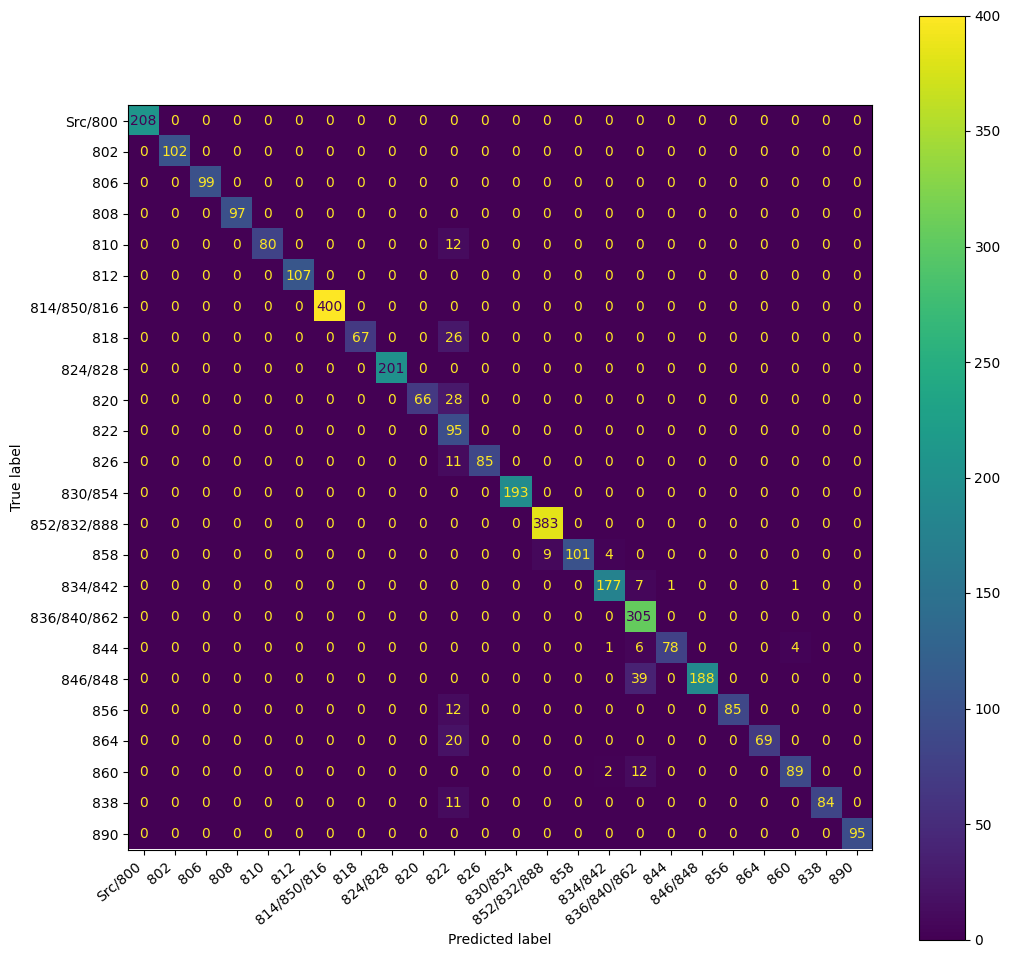

In [ ]:
#AUC Metric for PyTorch Models
#from torcheval.metrics.aggregation.auc import AUC
#metric = AUC()
from sklearn.metrics import roc_auc_score
from torch.nn import Softmax

Soft_list = np.array([[]]).reshape((0,24))
values_list = np.array([])
pred_list = np.array([])

with torch.no_grad():
    model.eval()
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        pred= out.argmax(dim=1)
        softmax = Softmax()
        softout = softmax(out)
        y = data.y
        Soft_list = np.concatenate((Soft_list, softout.numpy()), axis=0)
        pred_list = np.concatenate((pred_list, pred.numpy()), axis=0)
        # print(Soft_list)
        values_list= np.concatenate((values_list, y.numpy()), axis=None)
   # print(out)
   # print('*'*888)
   # print(softout)
   # print('*'*888)
print(Soft_list)
print(Soft_list.shape)
print(values_list)
print(values_list.shape)
print(pred_list)
print(pred_list.shape)

print("The Area Under ROC Curve (AUC) =", roc_auc_score(values_list, Soft_list, multi_class='ovr'))

from sklearn.metrics import f1_score
print("F1 Score =", f1_score(values_list, pred_list, average = 'macro'))

from sklearn.metrics import accuracy_score

print("Testing Accuracy =",accuracy_score(values_list, pred_list))

# Confusion Matrix for PyTorch Models
encoder = ['SourceBus', '800', '802', '806', '808', '810', '812', '814', '814r', '850',
'816', '818', '824', '820', '822', '826', '828', '830', '854', '832', '858',
'834', '860', '842', '836', '840', '862', '844', '846', '848', '852r', '888', '856', '852', '864', '838', '890']
print(encoder)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_mat_labels = ["Src/800", "802","806","808","810","812","814/850/816","818","824/828","820","822","826","830/854","852/832/888","858",
        "834/842","836/840/862","844","846/848","856","864","860","838","890"]

values_list = values_list.astype(object)
pred_list = pred_list.astype(object)

for faults in range(24):
    pred_list[pred_list==faults] = confusion_mat_labels[faults]
    values_list[values_list==faults] = confusion_mat_labels[faults]

print(confusion_mat_labels)
print(np.unique(values_list))
print(np.unique(pred_list))


# cm = confusion_matrix(values_list, pred_list, labels=confusion_mat_labels)#, labels=classes
# ConfusionMatrixDisplay(cm, display_labels=confusion_mat_labels).plot(xticks_rotation = 35).ax_.set_title("Cheb GCN Confusion Matrix")
# plt.show()
cm = confusion_matrix(values_list, pred_list,  labels=confusion_mat_labels)#, labels=classes
cmp = ConfusionMatrixDisplay(cm, display_labels=confusion_mat_labels)#.plot(xticks_rotation = 35)#.ax_.set_title("kNN Confusion Matrix")
fig, ax = plt.subplots(figsize=(12, 12))
#ax.set_xticks(xtick_labels-12)
cmp.plot(ax=ax, xticks_rotation = 40)
plt.xticks(np.arange(len(confusion_mat_labels)), confusion_mat_labels, ha='right')
plt.show()



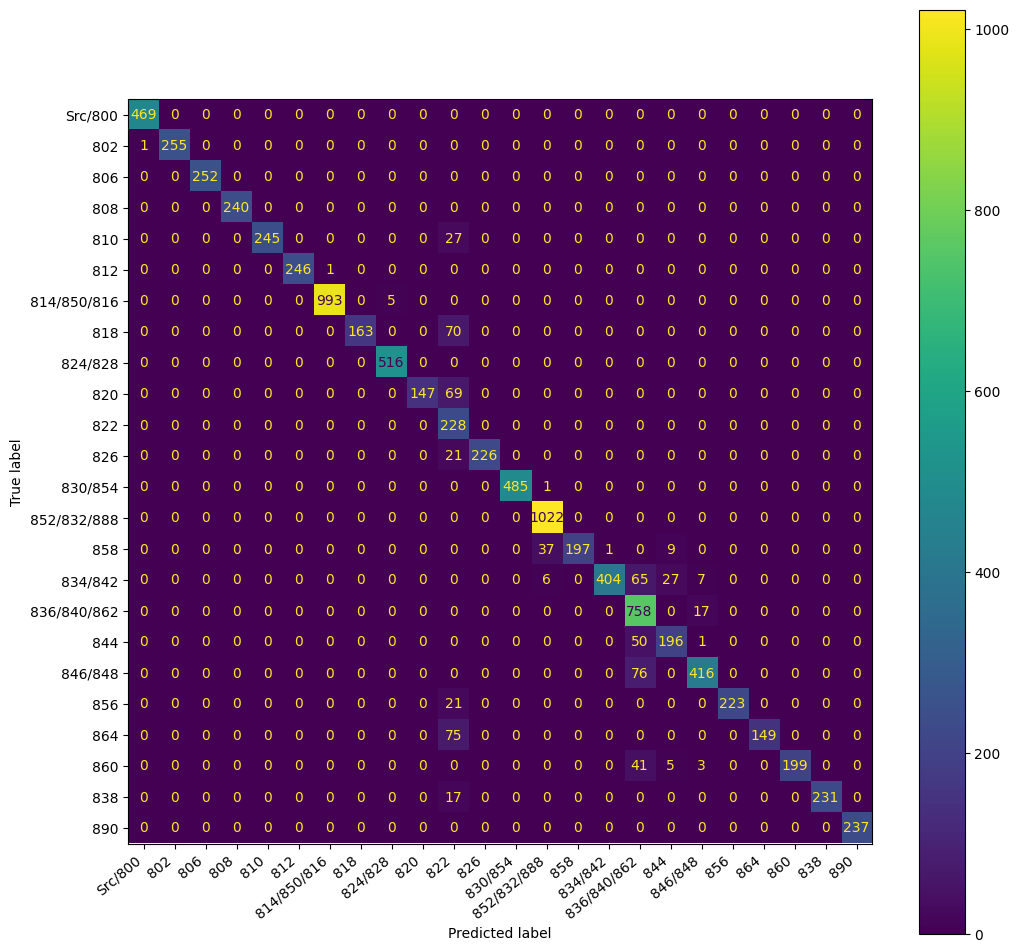

In [ ]:
cm = confusion_matrix(values_list, pred_list,  labels=confusion_mat_labels)#, labels=classes
cmp = ConfusionMatrixDisplay(cm, display_labels=confusion_mat_labels)#.plot(xticks_rotation = 35)#.ax_.set_title("kNN Confusion Matrix")
fig, ax = plt.subplots(figsize=(12, 12))
#ax.set_xticks(xtick_labels-12)
cmp.plot(ax=ax, xticks_rotation = 40)
plt.xticks(np.arange(len(confusion_mat_labels)), confusion_mat_labels, ha='right')
plt.show()